In [1]:
import sys
sys.path.append('..')

from helper_fun import *
import helper_fun
from Split_functions_classify.splits_two import *
from Split_functions_classify.splits_three import *
from Split_functions_classify.splits_ten import *

SEED = 22
seed_everything(SEED)

compounds = pd.read_csv('../COVID_MOONSHOT/compounds_filtered.csv')
compounds.head(2)

/home/alex/miniforge3/envs/my-rdkit-env-covid/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-07 16:11:59.827916: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 16:12:00.064305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Unnamed: 0,SMILES,CID,f_avg_IC50,r_avg_IC50,ROMol,molecular_weight,n_hba,n_hbd,logp,Ro5_fulfilled,f_avg_pIC50,r_avg_pIC50
0,35,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,DAR-DIA-23aa0b97-19,26.719515,14.641091,<rdkit.Chem.rdchem.Mol object at 0x7fc319ac34c0>,287.105862,3,1,3.28768,True,4.573171,4.834427
1,36,O=C(Cc1cncc2ccccc12)Nc1ccccc1,DAR-DIA-23aa0b97-20,57.590417,45.077469,<rdkit.Chem.rdchem.Mol object at 0x7fc319ac3530>,262.110613,2,1,3.41600,True,4.239650,4.346040


In [2]:
two_split(compounds)
three_split(compounds)
ten_split(compounds).head()
compound_df = compounds.copy()
compound_df["maccs"] = compound_df["SMILES"].apply(smiles_to_fp,)

In [3]:
#change variables to _2 at end
fingerprint_to_model = compound_df.maccs.tolist()
label_to_model_2 = compound_df.bin_2.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x_2,
    static_test_x_2,
    static_train_y_2,
    static_test_y_2,
) = train_test_split(fingerprint_to_model, label_to_model_2, test_size=0.2, random_state=SEED)
splits_2 = [static_train_x_2, static_test_x_2, static_train_y_2, static_test_y_2]

In [4]:
label_to_model_3 = compound_df.bin_3.to_list()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x_3,
    static_test_x_3,
    static_train_y_3,
    static_test_y_3,
) = train_test_split(fingerprint_to_model, label_to_model_3, test_size=0.2, random_state=SEED)
splits_3 = [static_train_x_3, static_test_x_3, static_train_y_3, static_test_y_3]

In [5]:
model_SVM_2 = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)
model_SVM_3 = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)
model_RF_2 = RandomForestClassifier(criterion="entropy")
model_RF_3 = RandomForestClassifier(criterion="entropy")
model_ANN_2 = MLPClassifier()
model_ANN_3 = MLPClassifier()

In [6]:
models = [{"label": "SVM binary", "model": model_SVM_2},{"label": "RF binary", "model": model_RF_2},{"label": "ANN binary", "model": model_ANN_2}]
models_3 = [{"label": "SVM ternary", "model": model_SVM_3},{"label": "RF ternary", "model": model_RF_3},{"label": "ANN ternary", "model": model_ANN_3}]

In [7]:
model_SVM_2.fit(static_train_x_2, static_train_y_2)
model_RF_2.fit(static_train_x_2, static_train_y_2)
model_ANN_2.fit(static_train_x_2, static_train_y_2)
model_SVM_3.fit(static_train_x_3, static_train_y_3)
model_RF_3.fit(static_train_x_3, static_train_y_3)
model_ANN_3.fit(static_train_x_3, static_train_y_3)

/home/alex/miniforge3/envs/my-rdkit-env-covid/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/miniforge3/envs/my-rdkit-env-covid/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

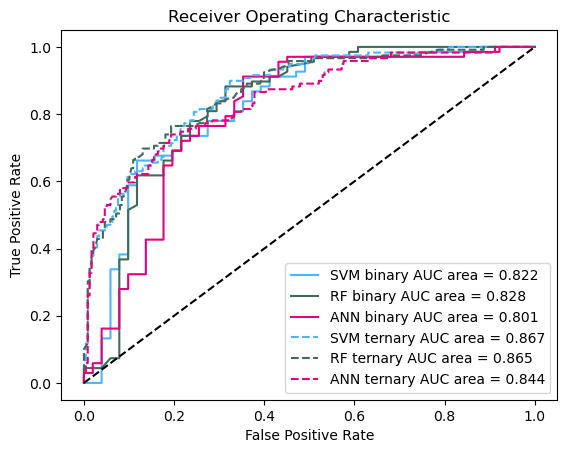

In [8]:
fig, ax = plt.subplots()
colours = ["#49B6FF", "#426A5A", "#E6007E"]
    # Below for loop iterates through your models list
i=0
for model in models:
    # Select the model
    ml_model = model["model"]
    # Prediction probability on test set
    test_prob = ml_model.predict_proba(static_test_x_2)[:, 1]
    # Prediction class on test set
    test_pred = ml_model.predict(static_test_x_2)
    # Compute False postive rate and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(static_test_y_2, test_prob)
    # Calculate Area under the curve to display on the plot
    auc_2 = roc_auc_score(static_test_y_2, test_prob)
    # Plot the computed values
    ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc_2:.3f}"),color=colours[i])
    i += 1

i = 0
for model in models_3:
    ml_model = model["model"]
    test_prob = ml_model.predict_proba(static_test_x_3)
    label_binarizer = LabelBinarizer().fit(static_train_y_3)
    y_onehot_test = label_binarizer.transform(static_test_y_3)
    fpr, tpr, roc_auc = dict(), dict(), dict()
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(),test_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])
    ax.plot(fpr["micro"], tpr["micro"], label=(f"{model['label']} AUC area = {roc_auc['micro']:.3f}"),color=colours[i],linestyle='dashed')
    i+=1
    
ax.plot([0, 1], [0, 1], "--",color='black')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver Operating Characteristic")
ax.legend(loc="lower right")

fig.savefig("roc_curve_RF_ANN_SVM", dpi=300, bbox_inches="tight", transparent=False)
